In this project, we'll work with exit surveys from employees of the Department of Education, Training and Employment (DETE) and the Technical and Further Education (TAFE) institute in Queensland, Australia.

We'll play the role of data analyst and pretend our stakeholders want to know the following:

-Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?

-Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

In [1]:
import pandas as pd
import numpy as np

dete_survey = pd.read_csv('http://opendata.dete.qld.gov.au/human-resources/dete-exit-survey-january-2014.csv', na_values = 'Not Stated')
tafe_survey = pd.read_csv('http://opendata.dete.qld.gov.au/human-resources/tafe-employee-exit-survey-access-database-december-2013.csv', encoding = "cp1252")

#dete_survey.isnull().sum()
#tafe_survey.isnull().sum()

dete_survey.head(5)

,ID,SeparationType,Cease Date,DETE Start Date,Role Start Date,Position,Classification,Region,Business Unit,Employment Status,...,Kept informed,Wellness programs,Health & Safety,Gender,Age,Aboriginal,Torres Strait,South Sea,Disability,NESB
0,1,Ill Health Retirement,08/2012,1984.0,2004.0,Public Servant,A01-A04,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,Yes
1,2,Voluntary Early Retirement (VER),08/2012,NaN,NaN,Public Servant,AO5-AO7,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,NaN
2,3,Voluntary Early Retirement (VER),05/2012,2011.0,2011.0,Schools Officer,NaN,Central Office,Education Queensland,Permanent Full-time,...,N,N,N,Male,61 or older,NaN,NaN,NaN,NaN,NaN
3,4,Resignation-Other reasons,05/2012,2005.0,2006.0,Teacher,Primary,Central Queensland,NaN,Permanent Full-time,...,A,N,A,Female,36-40,NaN,NaN,NaN,NaN,NaN
4,5,Age Retirement,05/2012,1970.0,1989.0,Head of Curriculum/Head of Special Education,NaN,South East,NaN,Permanent Full-time,...,N,A,M,Female,61 or older,NaN,NaN,NaN,NaN,NaN


As we can see:

-The dete_survey dataframe contains 'Not Stated' values that indicate values are missing, but they aren't represented as NaN.

-Both the dete_survey and tafe_survey dataframes contain many columns that we don't need to complete our analysis.

-Each dataframe contains many of the same columns, but the column names are different.

-There are multiple columns/answers that indicate an employee resigned because they were dissatisfied.
....
Let's drop some columns from each dataframe that we won't use in our analysis to make the dataframes easier to work with.


In [2]:
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis = 1)
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis = 1)

#Check colun names:
dete_survey_updated.columns
tafe_survey_updated.columns

Index(['Record ID', 'Institute', 'WorkArea', 'CESSATION YEAR',
       'Reason for ceasing employment',
       'Contributing Factors. Career Move - Public Sector ',
       'Contributing Factors. Career Move - Private Sector ',
       'Contributing Factors. Career Move - Self-employment',
       'Contributing Factors. Ill Health',
       'Contributing Factors. Maternity/Family',
       'Contributing Factors. Dissatisfaction',
       'Contributing Factors. Job Dissatisfaction',
       'Contributing Factors. Interpersonal Conflict',
       'Contributing Factors. Study', 'Contributing Factors. Travel',
       'Contributing Factors. Other', 'Contributing Factors. NONE',
       'Gender.     What is your Gender?', 'CurrentAge.     Current Age',
       'Employment Type.     Employment Type',
       'Classification.     Classification',
       'LengthofServiceOverall. Overall Length of Service at Institute (in years)',
       'LengthofServiceCurrent. Length of Service at current workplace (in ye

Next, let's turn our attention to the column names. Each dataframe contains many of the same columns

In [3]:
dete_survey_updated.columns = (
    dete_survey_updated.columns
    .str.replace(' ', '_')
    .str.replace('\s+', ' ')
    .str.strip()
    .str.lower()
    )

tafe_survey_updated = (
    tafe_survey_updated.rename(columns = {
        'Record ID' : 'id',
        'Reason for ceasing employment': 'separationtype',
        tafe_survey_updated.columns[17]: 'gender',
        tafe_survey_updated.columns[18]: 'age',
        'CESSATION YEAR': 'cease_date',
        tafe_survey_updated.columns[19]: 'employment_status',
        tafe_survey_updated.columns[20]: 'position',
        tafe_survey_updated.columns[21]: 'institute_service',
        tafe_survey_updated.columns[22]: 'role_service'})
)


Next, let's remove more of the data we don't need.

In [4]:
dete_survey_updated['separationtype'].value_counts()
resignation = (
    (dete_survey_updated['separationtype'] == 'Resignation-Other employer') |
    (dete_survey_updated['separationtype'] == 'Resignation-Other reasons') |
    (dete_survey_updated['separationtype'] == 'Resignation-Move overseas/interstate')
               )

dete_resignations = dete_survey_updated.loc[resignation,:].copy()

tafe_survey_updated['separationtype'].value_counts()
tafe_resignations = tafe_survey_updated.loc[tafe_survey_updated['separationtype'] == 'Resignation',:].copy()

print(dete_resignations['separationtype'].value_counts())
print(".......")
print(tafe_survey_updated['separationtype'].value_counts())

Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Name: separationtype, dtype: int64
.......
Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64


In this step, we'll focus on verifying that the years in the cease_date and dete_start_date columns make sense.

In [5]:
#dete_resignations['cease_date'].value_counts()
dete_resignations['cease_date'] = dete_resignations['cease_date'].str[-4:].astype('float')
dete_resignations['cease_date'].value_counts()

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: cease_date, dtype: int64

In [6]:
tafe_resignations['cease_date'].value_counts().sort_index()
dete_resignations['dete_start_date'].value_counts().sort_index()

1963.0     1
1971.0     1
1972.0     1
1973.0     1
1974.0     2
1975.0     1
1976.0     2
1977.0     1
1980.0     5
1982.0     1
1983.0     2
1984.0     1
1985.0     3
1986.0     3
1987.0     1
1988.0     4
1989.0     4
1990.0     5
1991.0     4
1992.0     6
1993.0     5
1994.0     6
1995.0     4
1996.0     6
1997.0     5
1998.0     6
1999.0     8
2000.0     9
2001.0     3
2002.0     6
2003.0     6
2004.0    14
2005.0    15
2006.0    13
2007.0    21
2008.0    22
2009.0    13
2010.0    17
2011.0    24
2012.0    21
2013.0    10
Name: dete_start_date, dtype: int64

Now that we've verified the years in the dete_resignations dataframe, we'll use them to create a new column. Recall that our end goal is to answer the following question:

Are employees who have only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been at the job longer?

Now let's count duration of work in dete_resignations

In [7]:
tafe_resignations.head(5)
dete_resignations['institute_service'] = dete_resignations['cease_date'] - dete_resignations['dete_start_date'] 
tafe_resignations['institute_service'].value_counts(dropna= False)
# dete_resignations.head(5)

Less than 1 year      73
1-2                   64
3-4                   63
NaN                   50
5-6                   33
11-20                 26
7-10                  21
More than 20 years    10
Name: institute_service, dtype: int64

Next, we'll identify any employees who resigned because they were dissatisfied.
First, let's make True/False state in tafe_resignations

In [8]:
tafe_resignations[['Contributing Factors. Job Dissatisfaction', 'Contributing Factors. Dissatisfaction']].head(34)

def update_val(val):
    if pd.isnull(val):
        val = np.nan
    elif val == '-':
        val = False
    else:
        val = True
    return val    


tafe_resignations[['Contributing Factors. Job Dissatisfaction', 'Contributing Factors. Dissatisfaction']] = tafe_resignations[['Contributing Factors. Job Dissatisfaction', 'Contributing Factors. Dissatisfaction']].applymap(update_val)

Second, we'll create a 'dissatisfied' column in BOTH the tafe_resignations and dete_resignations dataframes.

In [9]:
tafe_resignations['dissatisfied'] = tafe_resignations[['Contributing Factors. Dissatisfaction','Contributing Factors. Job Dissatisfaction']].any(axis=1, skipna=False)
tafe_resignations_up = tafe_resignations.copy()
tafe_resignations.head(2)

#defe_resignations['dissatisfied'] = date_resignationsp[].any()

,id,Institute,WorkArea,cease_date,separationtype,Contributing Factors. Career Move - Public Sector,Contributing Factors. Career Move - Private Sector,Contributing Factors. Career Move - Self-employment,Contributing Factors. Ill Health,Contributing Factors. Maternity/Family,...,Contributing Factors. Travel,Contributing Factors. Other,Contributing Factors. NONE,gender,age,employment_status,position,institute_service,role_service,dissatisfied
3,634139903350000000,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,-,-,...,Travel,-,-,NaN,NaN,NaN,NaN,NaN,NaN,False
4,634146578511788000,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,Career Move - Private Sector,-,-,-,...,-,-,-,Male,41 – 45,Permanent Full-time,Teacher (including LVT),3-4,3-4,False


In [10]:
dete_resignations['dissatisfied'] = dete_resignations[
    ['job_dissatisfaction',
     'dissatisfaction_with_the_department',
     'physical_work_environment',
     'lack_of_recognition',
     'lack_of_job_security',
     'work_location',
     'employment_conditions',
     'work_life_balance',
     'workload']].any(axis=1, skipna=False)

dete_resignations_up = dete_resignations.copy()

Our end goal is to aggregate the data according to the institute_service column/
First, let's add a column to each dataframe that will allow us to easily distinguish between the two. Second, we'll take only columns we really need in analysis ('age', 'institute', 'dissatisfied', 'institute_service')
Third, Combine the dataframes. 


In [11]:
#print(dete_resignations_up.columns)
#print('.......')
#print(tafe_resignations_up.columns)

print(dete_resignations_up['institute_service'].value_counts(dropna = False))
print('--------')
print(tafe_resignations_up['institute_service'].value_counts(dropna = False))

NaN     38
5.0     23
1.0     22
3.0     20
0.0     20
6.0     17
4.0     16
9.0     14
2.0     14
7.0     13
13.0     8
8.0      8
20.0     7
15.0     7
12.0     6
22.0     6
17.0     6
10.0     6
14.0     6
16.0     5
18.0     5
24.0     4
23.0     4
11.0     4
39.0     3
32.0     3
19.0     3
21.0     3
36.0     2
30.0     2
25.0     2
28.0     2
26.0     2
29.0     1
42.0     1
38.0     1
27.0     1
41.0     1
35.0     1
49.0     1
34.0     1
33.0     1
31.0     1
Name: institute_service, dtype: int64
--------
Less than 1 year      73
1-2                   64
3-4                   63
NaN                   50
5-6                   33
11-20                 26
7-10                  21
More than 20 years    10
Name: institute_service, dtype: int64


In [12]:
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'


dete_resignations_an = dete_resignations_up.copy()
tafe_resignations_an = tafe_resignations_up.copy()

tafe_resignations_an.head(3)

dete_resignations_an = dete_resignations_an[['age', 'institute', 'dissatisfied', 'institute_service']]
tafe_resignations_an = tafe_resignations_an[['age', 'institute', 'dissatisfied', 'institute_service']]

combined = pd.concat([dete_resignations_an,tafe_resignations_an], axis =0)

# combined['institute_service'].value_counts(dropna = False)
#combined.head(45)
# combined = pd.concat([dete_resignations_up, tafe_resignations_up], axis = 1)
combined_updated = combined.dropna(thresh = 500, axis = 1)
# combined.info
#combined['institute'].value_counts()

We'll use the slightly modified definitions below:

New: Less than 3 years at a company
Experienced: 3-6 years at a company
Established: 7-10 years at a company
Veteran: 11 or more years at a company
Let's categorize the values in the institute_service column using the definitions above.

In [13]:
combined['institute_service'] = combined['institute_service'].astype('str')

# new = r'Less than 1 year'
# experienced = 1
# established = 2
# veteran = 3

combined['institute_service'] = (combined['institute_service']
                                 .str.replace('Less than 1 year', '1')
                                 .str.replace('3-4','4')
                                 .str.replace('5-6','6')
                                 .str.replace('11-20','15')
                                 .str.replace('7-10','10')
                                 .str.replace('More than 20 years','20')
                                 .str.replace('1-2','2')
                                )
    
combined['institute_service'] = combined['institute_service'].astype('float')
print(combined['institute_service'].value_counts(dropna = False,).sort_index())
print(".......")

combined['age'] = combined['age'].astype('str')
# combined['age'].str.replace('-','...')
combined['age'].value_counts()



0.0     20
1.0     95
2.0     78
3.0     20
4.0     79
5.0     23
6.0     50
7.0     13
8.0      8
9.0     14
10.0    27
11.0     4
12.0     6
13.0     8
14.0     6
15.0    33
16.0     5
17.0     6
18.0     5
19.0     3
20.0    17
21.0     3
22.0     6
23.0     4
24.0     4
25.0     2
26.0     2
27.0     1
28.0     2
29.0     1
30.0     2
31.0     1
32.0     3
33.0     1
34.0     1
35.0     1
36.0     2
38.0     1
39.0     3
41.0     1
42.0     1
49.0     1
NaN     88
Name: institute_service, dtype: int64
.......


51-55            71
nan              55
41-45            48
41 – 45          45
46-50            42
36-40            41
46 – 50          39
26-30            35
21 – 25          33
36 – 40          32
26 – 30          32
31 – 35          32
31-35            29
21-25            29
56 or older      29
56-60            26
61 or older      23
20 or younger    10
Name: age, dtype: int64

Lets do the same with "age" column (Notice '–' and '-' difference! ):

In [20]:
# #'Gender. \xa0\xa0\xa0\xa0What is your Gender?'
combined['age'] = (combined['age']
                                 .str.replace('20 or younger', '20')
                                 .str.replace('21 – 25','25')
                                 .str.replace('21-25','25')
                                 .str.replace('26 – 30','30')
                                 .str.replace('26-30','30')
                                 .str.replace('31 – 35','35')
                                 .str.replace('31-35','35')
                                 .str.replace('36 – 40','40')
                                 .str.replace('36-40','40')
                                 .str.replace('41 – 45','45')
                                 .str.replace('41-45','45')
                                 .str.replace('46 – 50','50')
                                 .str.replace('46-50','50')
                                 .str.replace('51-55','55')
                                 .str.replace('56 or older','60')
                                 .str.replace('56-60','60')
                                 .str.replace('61 or older','60')
                   
                   
                   
                   
#                                   .str.replace('5-6','6')
#                                  .str.replace('11-20','15')
#                                  .str.replace('7-10','10')
#                                  .str.replace('More than 20 years','20')
#                                  .str.replace('1-2','2')
                                )
    
combined['age'].value_counts()    
combined['age'] = combined['age'].astype('float')
print(combined['age'].value_counts(dropna = False,).sort_index())

20.0    10
25.0    62
30.0    67
35.0    61
40.0    73
45.0    93
50.0    81
55.0    71
60.0    78
NaN     55
Name: age, dtype: int64


Next, we'll map each value to one of the career stage definitions above.


In [21]:
def stages(val):
    if pd.isnull(val):
        val = np.nan
    elif val < 3:
        val = '1.New'
    elif 3 <= val <= 6:
            val = '2.Experienced'
    elif 7 <= val <= 10:
            val = '3.Established'
    else:
        val = '4.Veteran'
        
    return val    
    
combined['service_cat'] = combined['institute_service'].apply(stages)
print(combined['service_cat'].value_counts(dropna = False))
print('.....')
print(combined['age'].value_counts())

1.New            193
2.Experienced    172
4.Veteran        136
NaN               88
3.Established     62
Name: service_cat, dtype: int64
.....
45.0    93
50.0    81
60.0    78
40.0    73
55.0    71
30.0    67
25.0    62
35.0    61
20.0    10
Name: age, dtype: int64


Now, let's finally do our first piece of analysis!

False    411
True     240
Name: dissatisfied, dtype: int64
               dissatisfied
service_cat                
1.New              0.295337
2.Experienced      0.343023
3.Established      0.516129
4.Veteran          0.485294


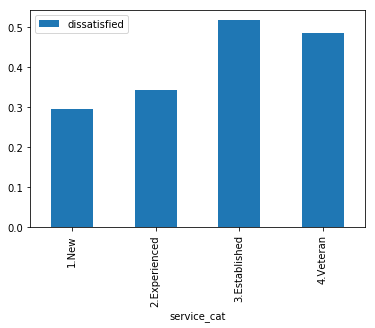

In [24]:
#combined['dissatisfied'].value_counts(dropna= False)
%matplotlib inline
combined['dissatisfied'] = combined['dissatisfied'].fillna(value = False)
print(combined['dissatisfied'].value_counts(dropna= False))

pivot_service = combined.pivot_table(values= 'dissatisfied' , index = 'service_cat' )     
pivot_service = pivot_service.sort_index(ascending = True)

print(pivot_service)

pivot_service.plot(kind = 'bar')

      dissatisfied
age               
20.0      0.200000
25.0      0.306452
30.0      0.417910
35.0      0.377049
40.0      0.342466
45.0      0.376344
50.0      0.382716
55.0      0.422535
60.0      0.423077


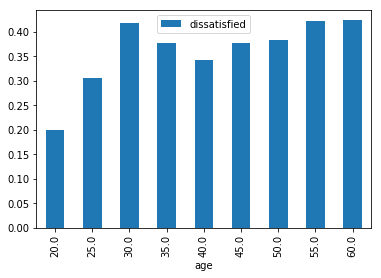

In [25]:
pivot_age = combined.pivot_table(values= 'dissatisfied' , index = 'age' )     
pivot_age = pivot_age.sort_index(ascending = True)
print(pivot_age)
pivot_age.plot(kind = 'bar')

Looks like we've done. 
Employees who only worked for the institutes for a short period of time resigning due to some other reasons. About half of establshed and veterans resigning due to some kind of dissatisfaction. Young  employees resigning due to some other reasons